In [1]:
%reload_ext autoreload
%matplotlib inline
%autoreload 2

import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [2]:
tf.keras.backend.set_floatx('float64')

np.set_printoptions(suppress=True, precision=3, linewidth=120)

In [3]:
def mae(y_trues, y_preds):
    return np.mean(np.abs(y_trues-y_preds))

def rmse(y_trues, y_preds):
    return np.sqrt(np.mean(np.power(y_trues-y_preds, 2)))

def mrae(y_trues, y_preds):
    return np.mean(np.abs(np.divide(y_trues -y_preds, y_trues)))

In [4]:
def plot_loss(history, name):
    _ = plt.figure(figsize=(13.5, 7.5))
    plt.plot(history.history['loss'], label='Train Loss-' + name)
    plt.plot(history.history['val_loss'], label='Test Loss' + name)
    plt.ylabel("Error")
    plt.xlabel("Epochs")
    plt.legend()
    plt.title("Train- test Erros for " + name)
    plt.show()
    


def plot_predictions(y_test, y_pred, name):
    _ = plt.figure(figsize=(13.5, 7.5))
    plt.scatter(y_test, y_pred)
    plt.xlabel("True Values ("+ name+")")
    plt.ylabel("True Values ("+ name+")")
    plt.title("Scatter plot of target values vs predicted values")
    


def plot_error_distribution(y_test, y_pred, name, n_bins):
    error = y_pred - y_test
    plt.hist(error, bins=n_bins)
    plt.xlabel("Prediction Error (" + name + ")")
    plt.ylabel('Count')
    

### Load data set and split it

In [5]:
pld_complete_zscore = pd.read_csv("../../data/pld_complete_zscore.csv", index_col=False)
pld_complete_range = pd.read_csv("../../data/pld_complete_range.csv", index_col=False)
pld_complete = catalog.load('pld_complete').dropna().sort_values('pos', ascending=True)

2020-11-25 21:44:33,922 - kedro.io.data_catalog - INFO - Loading data from `pld_complete` (ParquetDataSet)...
2020-11-25 21:44:34,110 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


In [6]:
x_z = pld_complete_zscore.loc[:, ~pld_complete_zscore.columns.isin(
    ['Ic', 'Ic_norm', 'pos'])].to_numpy()

x_r = pld_complete_range.loc[:, ~pld_complete_range.columns.isin(
    ['Ic', 'Ic_norm', 'pos'])].to_numpy()

y_ic = pld_complete_range['Ic'].to_numpy()
y_ic_norm = pld_complete_range['Ic_norm'].to_numpy()

pos = pld_complete_range['pos'].to_numpy()

x_z.shape, x_r.shape, y_ic.shape, y_ic_norm.shape, pos.shape

((18561, 382), (18561, 376), (18561,), (18561,), (18561,))

### Ic train test split

In [7]:
x_r_train_ic, x_r_test_ic, y_train_ic, y_test_ic = train_test_split(x_r, y_ic,
                                                                    test_size=0.25,
                                                                    random_state=43,)

x_r_train_ic.shape, x_r_test_ic.shape, y_train_ic.shape, y_test_ic.shape

((13920, 376), (4641, 376), (13920,), (4641,))

### Ic_Norm train test split

In [8]:
x_r_train_ic_norm, x_r_test_ic_norm, y_train_ic_norm, y_test_ic_norm = train_test_split(x_r, y_ic_norm,
                                                                    test_size=0.25,
                                                                    random_state=43,)

x_r_train_ic_norm.shape, x_r_test_ic_norm.shape, y_train_ic_norm.shape, y_test_ic_norm.shape

((13920, 376), (4641, 376), (13920,), (4641,))

### DNN-Regressor

In [11]:
class DnnRegressor(tf.keras.Model):
    
    def __init__(self, n_units, n_features, name='dnn_regressor', **kwargs):
        super(DnnRegressor, self).__init__(name=name, **kwargs)
        self.n_units = n_units
        self.n_features = n_features
        
        self.dense_1 = tf.keras.layers.Dense(units=self.n_units, activation='relu', 
                                               input_shape=(self.n_features, ))
        self.dense_2 = tf.keras.layers.Dense(units=self.n_units, activation='relu')
        self.regressor = tf.keras.layers.Dense(units=1)
    
    def call(self, inputs):
        x = self.dense_1(inputs,)
        x = self.dense_2(x)
        regression = self.regressor(x)
        return regression



In [12]:
# instantiate
n_units_ic = 64

n_units_ic_norm = 64

dnn_regression_model_ic = DnnRegressor(n_units=n_units_ic, n_features=x_r.shape[1])
dnn_regression_model_ic_norm = DnnRegressor(n_units=n_units_ic_norm, n_features=x_r.shape[1])
        

In [13]:
n_epochs_ic = 500
learning_rate_ic = 0.1

dnn_regression_model_ic.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=learning_rate_ic),
                         loss=tf.keras.losses.MeanSquaredError()) #  'mean_absolute_error', )

In [14]:
%%time
history_ic = dnn_regression_model_ic.fit(x=x_r_train_ic, y=y_train_ic,
                                         validation_data=(x_r_test_ic, y_test_ic),
                                         epochs=n_epochs_ic,
                                         batch_size=128)

Epoch 1/500
109/109 [==============================] - 0s 4ms/step - loss: 8424.9516 - val_loss: 614.6076
Epoch 2/500
109/109 [==============================] - 0s 3ms/step - loss: 463.7256 - val_loss: 337.5850
Epoch 3/500
109/109 [==============================] - 0s 3ms/step - loss: 304.4537 - val_loss: 266.6542
Epoch 4/500
109/109 [==============================] - 0s 3ms/step - loss: 234.2559 - val_loss: 235.3020
Epoch 5/500
109/109 [==============================] - 0s 3ms/step - loss: 200.1099 - val_loss: 176.4846
Epoch 6/500
109/109 [==============================] - 0s 3ms/step - loss: 173.2937 - val_loss: 171.8326
Epoch 7/500
109/109 [==============================] - 0s 3ms/step - loss: 157.1292 - val_loss: 151.8893
Epoch 8/500
109/109 [==============================] - 0s 3ms/step - loss: 143.8454 - val_loss: 138.8714
Epoch 9/500
109/109 [==============================] - 0s 3ms/step - loss: 133.3805 - val_loss: 125.5806
Epoch 10/500
109/109 [==============================] 

109/109 [==============================] - 0s 3ms/step - loss: 46.8030 - val_loss: 58.6977
Epoch 80/500
109/109 [==============================] - 0s 3ms/step - loss: 46.4405 - val_loss: 53.0515
Epoch 81/500
109/109 [==============================] - 0s 3ms/step - loss: 46.0425 - val_loss: 55.7692
Epoch 82/500
109/109 [==============================] - 0s 2ms/step - loss: 46.3904 - val_loss: 54.7135
Epoch 83/500
109/109 [==============================] - 0s 3ms/step - loss: 45.8436 - val_loss: 53.0348
Epoch 84/500
109/109 [==============================] - 0s 3ms/step - loss: 45.1985 - val_loss: 56.1274
Epoch 85/500
109/109 [==============================] - 0s 3ms/step - loss: 45.5090 - val_loss: 54.9872
Epoch 86/500
109/109 [==============================] - 0s 3ms/step - loss: 45.0060 - val_loss: 54.0164
Epoch 87/500
109/109 [==============================] - 0s 3ms/step - loss: 45.5409 - val_loss: 56.8427
Epoch 88/500
109/109 [==============================] - 0s 2ms/step - loss: 4

109/109 [==============================] - 0s 3ms/step - loss: 37.2722 - val_loss: 47.2206
Epoch 158/500
109/109 [==============================] - 0s 3ms/step - loss: 37.7542 - val_loss: 47.7185
Epoch 159/500
109/109 [==============================] - 0s 3ms/step - loss: 36.7286 - val_loss: 47.0723
Epoch 160/500
109/109 [==============================] - 0s 3ms/step - loss: 36.7283 - val_loss: 47.6986
Epoch 161/500
109/109 [==============================] - 0s 3ms/step - loss: 36.9832 - val_loss: 46.3986
Epoch 162/500
109/109 [==============================] - 0s 3ms/step - loss: 37.3275 - val_loss: 46.7095
Epoch 163/500
109/109 [==============================] - 0s 3ms/step - loss: 37.0996 - val_loss: 46.7749
Epoch 164/500
109/109 [==============================] - 0s 3ms/step - loss: 37.0574 - val_loss: 48.0248
Epoch 165/500
109/109 [==============================] - 0s 2ms/step - loss: 36.7654 - val_loss: 46.6856
Epoch 166/500
109/109 [==============================] - 0s 3ms/step 

109/109 [==============================] - 0s 2ms/step - loss: 33.0707 - val_loss: 45.2291
Epoch 236/500
109/109 [==============================] - 0s 2ms/step - loss: 33.6907 - val_loss: 45.6467
Epoch 237/500
109/109 [==============================] - 0s 2ms/step - loss: 33.0881 - val_loss: 44.5975
Epoch 238/500
109/109 [==============================] - 0s 2ms/step - loss: 33.5736 - val_loss: 45.4040
Epoch 239/500
109/109 [==============================] - 0s 2ms/step - loss: 32.8012 - val_loss: 45.5875
Epoch 240/500
109/109 [==============================] - 0s 2ms/step - loss: 33.2574 - val_loss: 45.0102
Epoch 241/500
109/109 [==============================] - 0s 2ms/step - loss: 33.1153 - val_loss: 47.3339
Epoch 242/500
109/109 [==============================] - 0s 2ms/step - loss: 33.1927 - val_loss: 44.2829
Epoch 243/500
109/109 [==============================] - 0s 2ms/step - loss: 33.1924 - val_loss: 43.9536
Epoch 244/500
109/109 [==============================] - 0s 4ms/step 

109/109 [==============================] - 0s 2ms/step - loss: 30.5636 - val_loss: 44.2828
Epoch 314/500
109/109 [==============================] - 0s 2ms/step - loss: 30.6381 - val_loss: 42.1272
Epoch 315/500
109/109 [==============================] - 0s 2ms/step - loss: 30.3904 - val_loss: 42.9448
Epoch 316/500
109/109 [==============================] - 0s 2ms/step - loss: 30.7934 - val_loss: 43.2826
Epoch 317/500
109/109 [==============================] - 0s 2ms/step - loss: 30.5845 - val_loss: 43.6883
Epoch 318/500
109/109 [==============================] - 0s 2ms/step - loss: 30.5726 - val_loss: 42.2453
Epoch 319/500
109/109 [==============================] - 0s 2ms/step - loss: 30.3176 - val_loss: 41.8939
Epoch 320/500
109/109 [==============================] - 0s 2ms/step - loss: 30.3085 - val_loss: 43.1004
Epoch 321/500
109/109 [==============================] - 0s 2ms/step - loss: 30.3696 - val_loss: 42.6678
Epoch 322/500
109/109 [==============================] - 0s 2ms/step 

109/109 [==============================] - 0s 2ms/step - loss: 28.9232 - val_loss: 41.7846
Epoch 392/500
109/109 [==============================] - 0s 2ms/step - loss: 28.6492 - val_loss: 41.3252
Epoch 393/500
109/109 [==============================] - 0s 2ms/step - loss: 28.8054 - val_loss: 42.3526
Epoch 394/500
109/109 [==============================] - 0s 2ms/step - loss: 28.7299 - val_loss: 41.6301
Epoch 395/500
109/109 [==============================] - 0s 2ms/step - loss: 28.6685 - val_loss: 41.1751
Epoch 396/500
109/109 [==============================] - 0s 2ms/step - loss: 28.8170 - val_loss: 43.5532
Epoch 397/500
109/109 [==============================] - 0s 2ms/step - loss: 28.6670 - val_loss: 41.3046
Epoch 398/500
109/109 [==============================] - 0s 2ms/step - loss: 28.6232 - val_loss: 42.6536
Epoch 399/500
109/109 [==============================] - 0s 2ms/step - loss: 28.8651 - val_loss: 47.2821
Epoch 400/500
109/109 [==============================] - 0s 2ms/step 

109/109 [==============================] - 0s 2ms/step - loss: 27.1765 - val_loss: 43.6330
Epoch 470/500
109/109 [==============================] - 0s 2ms/step - loss: 27.1436 - val_loss: 42.3233
Epoch 471/500
109/109 [==============================] - 0s 2ms/step - loss: 27.5234 - val_loss: 41.1759
Epoch 472/500
109/109 [==============================] - 0s 2ms/step - loss: 27.1061 - val_loss: 41.8219
Epoch 473/500
109/109 [==============================] - 0s 2ms/step - loss: 27.3936 - val_loss: 40.5724
Epoch 474/500
109/109 [==============================] - 0s 2ms/step - loss: 27.3376 - val_loss: 41.2521
Epoch 475/500
109/109 [==============================] - 0s 2ms/step - loss: 27.2476 - val_loss: 40.9514
Epoch 476/500
109/109 [==============================] - 0s 2ms/step - loss: 27.8320 - val_loss: 41.2550
Epoch 477/500
109/109 [==============================] - 0s 2ms/step - loss: 27.2138 - val_loss: 41.6459
Epoch 478/500
109/109 [==============================] - 0s 2ms/step 

In [15]:
dnn_regression_model_ic.summary()

Model: "dnn_regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  24128     
_________________________________________________________________
dense_1 (Dense)              multiple                  4160      
_________________________________________________________________
dense_2 (Dense)              multiple                  65        
Total params: 28,353
Trainable params: 28,353
Non-trainable params: 0
_________________________________________________________________


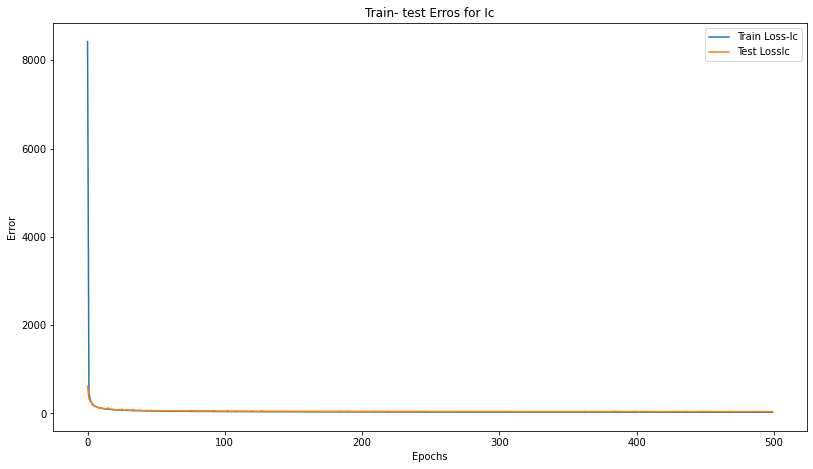

In [16]:
plot_loss(history=history_ic, name='Ic')

In [17]:
y_hat_ic = dnn_regression_model_ic.predict(x_r_test_ic)


mae_ic = mae(y_trues=y_test_ic, y_preds=y_hat_ic)
rmse_ic = rmse(y_trues=y_test_ic, y_preds=y_hat_ic)
mrae_ic = mrae(y_trues=y_test_ic, y_preds=y_hat_ic)

print("DNN-Regression Performance for Ic:", 
     "MAE: %.3f" % mae_ic, 
      "RMSE: %.3f" % rmse_ic, 
      "MRAE: %.3f" % mrae_ic,)

DNN-Regression Performance for Ic: MAE: 11.855 RMSE: 15.699 MRAE: 0.024


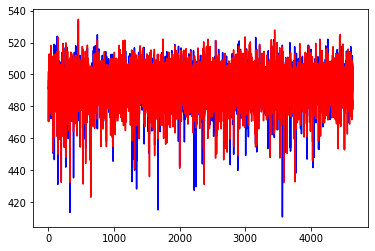

In [18]:
plt.plot(y_test_ic, c='b')

plt.plot(y_hat_ic, c='r')
plt.show()

### Conclusion:

After spending quite a few days on training several architectures of NN for predicting IC or IC_Norm as a conclusion I can say that Random Forest or GDB-LS are the best solutions for this task.

- Note: I have tried several choices of epochs, units, different optimizers, batch-size, learning rate and none of those attempts has yielded an acceptable MRAE.

Below you can find DNN-Reg for Ic_Norm

In [25]:
n_units_ic_norm = 64
n_epochs_ic_norm = 500
learning_rate_ic_norm = 0.1



dnn_regression_model_ic_norm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_ic_norm),
                         loss=tf.keras.losses.MeanSquaredError())

In [26]:
%%time
history_ic_norm = dnn_regression_model_ic_norm.fit(x=x_r_train_ic_norm, y=y_train_ic_norm,
                                                   validation_data=(x_r_test_ic_norm, y_test_ic_norm),
                                                   epochs=n_epochs_ic_norm, batch_size=128)

Epoch 1/500
109/109 [==============================] - 0s 3ms/step - loss: 52.3612 - val_loss: 0.2872
Epoch 2/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0568 - val_loss: 0.0017
Epoch 3/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 4/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 5/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 6/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 7/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 8/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 9/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 10/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_l

109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 82/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 83/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 84/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 85/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 86/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 87/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 88/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 89/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 90/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 

Epoch 161/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 162/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 163/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 164/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 165/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 166/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 167/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 168/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 169/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 170/500
109/109 [==============================] - 0s 3ms/step - lo

109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 241/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 242/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 243/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 244/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 245/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 246/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 247/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 248/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 249/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - v

109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 320/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 321/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 322/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 323/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 324/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 325/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 326/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 327/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 328/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - v

109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 399/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 400/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 401/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 402/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 403/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 404/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 405/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 406/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 407/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - v

109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 478/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 479/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 480/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 481/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 482/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 483/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 484/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 485/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 486/500
109/109 [==============================] - 0s 3ms/step - loss: 0.0013 - v

In [27]:
dnn_regression_model_ic_norm.summary()

Model: "dnn_regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  24128     
_________________________________________________________________
dense_4 (Dense)              multiple                  4160      
_________________________________________________________________
dense_5 (Dense)              multiple                  65        
Total params: 28,353
Trainable params: 28,353
Non-trainable params: 0
_________________________________________________________________


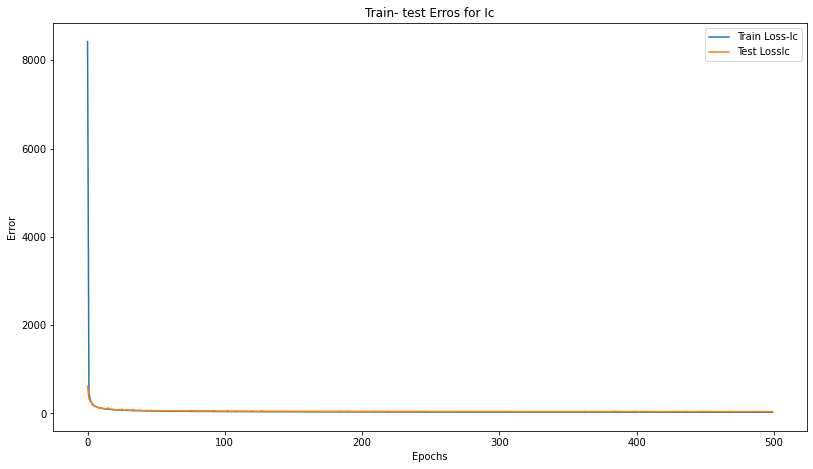

In [28]:
plot_loss(history=history_ic, name='Ic')

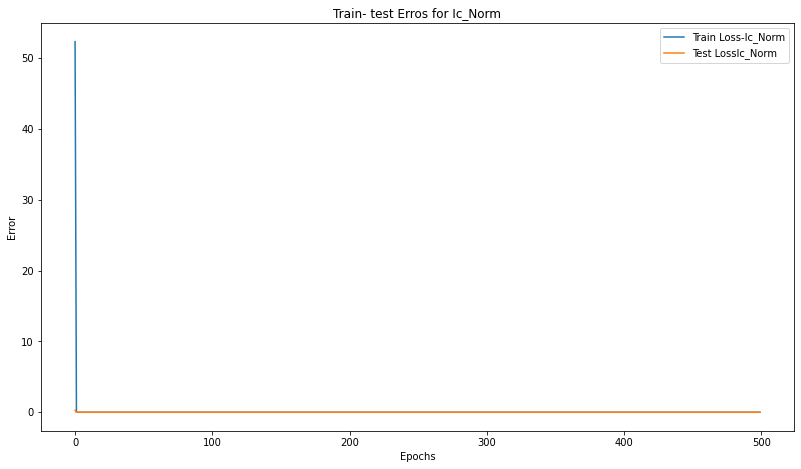

In [29]:
plot_loss(history=history_ic_norm, name='Ic_Norm')

In [31]:
y_hat_ic_norm = dnn_regression_model_ic_norm.predict(x_r_test_ic_norm)

In [32]:
mae_ic_norm = mae(y_trues=y_test_ic_norm, y_preds=y_hat_ic_norm)
rmse_ic_norm = rmse(y_trues=y_test_ic_norm, y_preds=y_hat_ic_norm)
mrae_ic_norm = mrae(y_trues=y_test_ic_norm, y_preds=y_hat_ic_norm)

print("DNN-Regression Performance for Ic_norm:", 
     "MAE: %.3f" % mae_ic_norm, 
      "RMSE: %.3f" % rmse_ic_norm, 
      "MRAE: %.3f" % mrae_ic_norm,)

DNN-Regression Performance for Ic_norm: MAE: 0.028 RMSE: 0.036 MRAE: 0.016
